DSC-550 Neural Networks and Deep Learning<br>
Topic 4 Neural Network Solution<br>
Tyler Tschanz<br>

# Image Classification of Clothing Items #

# 1. Problem Statement #

The goal of the project is to develop a deep learning model capable of classifying images of clothing items into 10 distinct categories with an accuracy of at least 85%." Accurate image classification of clothing items has applications in e-commerce (product categorization, visual search), fashion analysis (trend detection), and inventory management. Utilization of this model can reduce manual labeling costs, provide better product recommendations, and enhance search functionality. Fashion retailers could also automate cataloging and manage supply chains more effectively.


# 2. Approach and Software Tools # 

We'll use a Convolutional Neural Network (CNN) for image classification. CNNs are well-suited for image processing due to their ability to learn spatial hierarchies in data.

## Software Tools: ##
Python: Programming language. <br>
TensorFlow/Keras: Deep learning framework.<br>
NumPy: Numerical computation.<br>
Pandas: Data manipulation.<br>
Matplotlib/Seaborn: Data visualization.<br>
Scikit-learn: Model evaluation.<br>
Google Colab/AWS SageMaker (or another cloud platform): For training and deployment.<br>

# 3. Theoretical (Algorithmic) Foundations #

Convolutional Neural Networks (CNNs):
Convolutional Layers: Extract features from images using filters.
Pooling Layers: Reduce the spatial dimensions of feature maps.
Activation Functions: Introduce non-linearity (e.g., ReLU).
Fully Connected Layers: Perform classification based on learned features.
Loss Function: Categorical Cross-Entropy (for multi-class classification).
Optimizer: Adam or SGD (for updating model weights).

# Dataset: Fashion-MNIST #

This project utilizes the Fashion-MNIST dataset (Xiao et. al, 2017), which consists of 60,000 training images and 10,000 test images, each a 28x28 grayscale image, associated with a label from 10 classes. This dataset is readily available through Keras datasets and does not require cleaning or handling of missing values or labels. Additionally, since pixel values are bounded (0-255), outliers will not need to be handled.

Data Processing:
Load the Fashion-MNIST dataset.
Preprocess the data (normalization).
Split into training and validation sets.
Create the CNN model using Keras.
Compile the model (specify loss, optimizer, metrics).
Train the model using the training data.
Evaluate the model using the validation data.
Make predictions on the test set.
Computational Results and Interpretation:
Show training and validation loss/accuracy curves.
Display the confusion matrix.
Analyze misclassified images.
Performance Metrics:
Accuracy, precision, recall, F1-score.
Use classification_report from scikit-learn.
Parameter Tuning:
Experiment with different architectures (number of layers, filters, kernel sizes).
Adjust learning rate, batch size, and number of epochs.
Use techniques like dropout or batch normalization to improve generalization.

Cloud Deployment:
Use Google Colab for training (free GPU access).
Deploy the trained model to Google Cloud Platform (GCP) using TensorFlow Serving or Cloud Functions.
Justification for GCP:
TensorFlow Serving integrates well with TensorFlow models.
Cloud Functions provide serverless deployment.
GCP offers a comprehensive suite of AI/ML services.
7. Summary

Overall Usefulness: The model can accurately classify clothing images, enabling various applications.
Functionality: The model takes an image as input and outputs the predicted class label.
Performance: Evaluate the model's performance using accuracy, precision, recall, and F1-score.

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
# Load the Fashion-MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



# Data Analysis and Preprocessing # 

After loading the dataset and assigning the class names variable we will display some sample images and check the class distribution via a histogram. We also calculate mean and standard deviation of pixel values. Next we normalize pixel values to the range [0, 1] by dividing by 255 as this improves training stability and convergence.Neural networks, especially CNNs, tend to converge more quickly and reliably when their inputs lie in a smaller, standardized range (e.g., [0,1] or [−1,1]). Large raw values (like 0–255 for pixels) can cause gradients to explode or vanish during training. Normalization is the go to over standarization for this dataset as it is easy to interpret ( 0 = black, 1 = white in grayscale) and is also widely used for classification tasks. Standardization could work, but is more common when feature distributions vary widley, or you want to the data to have zero mean. (Scikit-learn,n.d.)

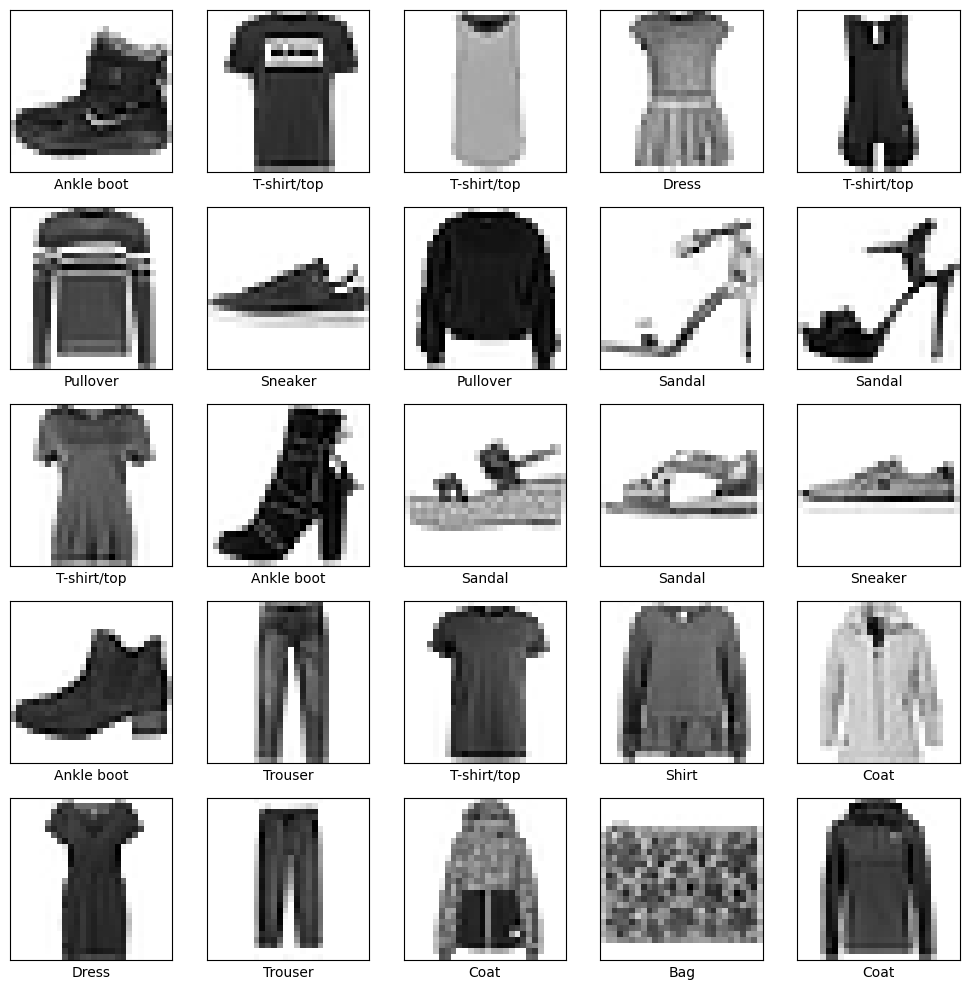

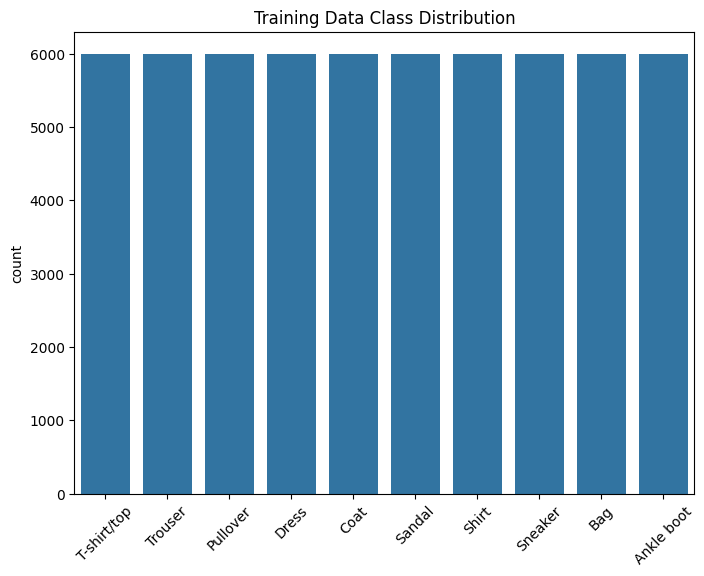

Pixel value range: 0 - 255
Mean pixel value: 72.94035223214286
Standard deviation: 90.02118235130519


In [3]:
# Class names for labeling plots
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.tight_layout()
plt.show()

# Check class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels)
plt.xticks(ticks=range(10), labels=class_names, rotation=45)
plt.title("Training Data Class Distribution")
plt.show()

# Pixel value statistics
print("Pixel value range:", train_images.min(), "-", train_images.max())
print("Mean pixel value:", train_images.mean())
print("Standard deviation:", train_images.std())

In [4]:
# Step 4: Data Preprocessing
# Normalize pixel values to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Expand dimensions to add channel dimension (for CNN input)
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Create a validation set from training data (e.g., 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, 
                                                  test_size=0.2, random_state=42)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an ImageDataGenerator for augmentations
train_datagen = ImageDataGenerator(
    rotation_range=15,      # rotate images by up to 15 degrees
    width_shift_range=0.1,  # shift images horizontally by up to 10%
    height_shift_range=0.1, # shift images vertically by up to 10%
    shear_range=0.1,        # shear intensity
    zoom_range=0.1          # zoom in/out by up to 10%
)

# Fit the generator to the training data 
train_datagen.fit(X_train)

This image augmentation should help combat overfitting by the model.

In [19]:
# Step 5: Build the CNN Model

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

c:\Users\tschanz\.jupyter\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,418 (880.54 KB)

 Trainable params: 225,226 (879.79 KB)

 Non-trainable params: 192 (768.00 B)

# Theoretical Foundation of the Model #


##  Convolutional Layers

Let the input image be <br>
x ∈ R^28*28*1.


A 2D convolution with K filters of size k*k  can be written as:


(Conv2D_K,k*k(x))_m= ∑_(c=1)^{C_(in}) ∑_{p=1}^{k} ∑_{q=1}^{k} W_(m,c,p,q), x_(c),i+p-1,j+q-1 + b_m


where:
- x_{c,i,j} is the pixel (or feature) value at channel c and spatial location (i,j).
- C_{in} is the number of input channels (for the first layer, C_{in} = 1).
- m indexes the output filter (1 <= m <= K).
- W_{m,c,p,q} and b_m are the learnable weights and biases for filter m.
(Aggarwal, 2018; Shanmugamani, 2018).

In this model, we apply two such convolutional layers:
1. **First Conv2D** with 32 filters, each 3 * 3.
2. **Second Conv2D** with 64 filters, each 3 * 3.


---

## Batch Normalization

After each convolution, we apply Batch Normalization (BN). Given an activation map z with mean mu and variance σ^2 (estimated from the current batch), BN is defined as: <br>
z-hat = (z-μ)/sqrt(σ^2+$\epsilon$), BN(z) =γz-hat + $\beta$

where $\gamma$ and $\beta$ are learnable parameters (one pair per channel), and $\epsilon$ is a small constant to avoid division by zero.
(Ioffe & Szegedy, 2015).
---

## Activation Function (ReLU)

The Rectified Linear Unit (ReLU) is applied element-wise. For a scalar input s:

α(s) = max(0,s)


---

## Max Pooling

Max pooling with a 2 X 2 window and stride 2 is defined as:

(MaxPool2D(z))_(c,i,,j) = max_{0 <= p, q < 2}; z_{c,(2i + p),(2j + q)}.


This reduces the spatial dimension by selecting the maximum value within each 2 X 2 patch.
(Aggarwal, 2018; Shanmugamani, 2018).
---

## Dropout

Dropout randomly zeroes out a fraction p of the activations during training. If z is your activation tensor, then:

\[
(Dropout(z; p))_i = 
\begin{cases} 
0, & \text{with probability } p,\\
\dfrac{z_i}{1-p}, & \text{with probability } (1 - p).
\end{cases}
\]

This helps mitigate overfitting by preventing co-adaptation of neurons.
(Aggarwal, 2018; Shanmugamani, 2018).
---

## Flatten

After the second convolutional block, we flatten the 2D feature maps into a 1D vector. If the feature maps have shape (C, H, W), then:

Flatten(z) ∈ R6(C * H * W)


simply rearranges the tensor into a single dimension of length C X H X W.

---

## Dense (Fully Connected) Layers

A Dense layer with D_{in} inputs and D_{out} outputs is given by:

Dense(z) = Wz + b,


where W ∈ R^(D_{out} * D_{in}) and b ∈ R^D_{{out} are learnable parameters.

In this model:
1. **Dense Layer** with 128 units (ReLU activation).
2. **Dense Layer** with 10 units, followed by softmax.

---

## Softmax Output

The final output is a probability distribution over 10 classes via the softmax function. For a vector U ∈ R^10:

Softmax(U)_i = exp(ui)/∑^10,exp(uj) 

This ensures the outputs are in \((0,1)\) and sum to 1.

(Aggarwal, 2018; Shanmugamani, 2018).
---

## Overall Forward Pass
 We can break it into blocks:

1. **First Conv Block**  


2. **Second Conv Block**  


3. **Flatten**  


4. **Dense + ReLU**  


5. **Dense + Softmax**  


---

## 1Loss Function and Optimization

This model uses **sparse categorical cross-entropy** as the loss function. If y is the true class index (0–9) and f(x)_c is the predicted probability for class c, then:

L(y, f(x)) = -ln(f(x)_y)


Over a training set {(x^{(i)}, y^{(i)}_{i=1}^N, the model parameters θ are optimized by minimizing:


min_{θ} 1/N N∑_(i=1)L(y^i, f(x^i;θ ))


We employ the **Adam** optimizer, which adaptively adjusts the learning rate based on first- and second-moment estimates of the gradients.

---

##  Summary

In mathematical form, the model transforms a 28 X 28-pixel grayscale image through two convolution–batchnorm–ReLU–maxpool–dropout blocks, flattens the resulting feature maps, and then applies two dense layers, with a final softmax to produce a 10-dimensional probability distribution. The training objective is to minimize the sparse categorical cross-entropy between the predicted distribution and the true label, and the optimization is carried out via Adam.


# Model Diagram #
Input (28x28 grayscale image) -> Convolutional Layer -> ReLU -> Pooling -> Convolutional Layer -> ReLU -> Pooling -> Flatten -> Fully Connected Layer -> ReLU -> Fully Connected Layer (Output, 10 classes) -> Softmax.

In [20]:
# Step 6: Set Up Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [21]:
# Step 7: Train the Model
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, checkpoint])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.6936 - loss: 0.9200 - val_accuracy: 0.8544 - val_loss: 0.3934
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.8254 - loss: 0.4730 - val_accuracy: 0.8811 - val_loss: 0.3279
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.8555 - loss: 0.3997 - val_accuracy: 0.8813 - val_loss: 0.3166
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.8644 - loss: 0.3751 - val_accuracy: 0.8944 - val_loss: 0.2901
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.8733 - loss: 0.3473 - val_accuracy: 0.8987 - val_loss: 0.2758
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.8811 - loss: 0.3251 - val_accuracy: 0.8838 - val_loss: 0.3014
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.8839 - loss: 0.3134 - val_accuracy: 0.8446 - val_loss: 0.4639
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.8861 - loss: 0.3098 - 

In [22]:
# Step 8: Evaluate the Model on the Test Set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9112 - loss: 0.2609
Test Accuracy: 91.22%


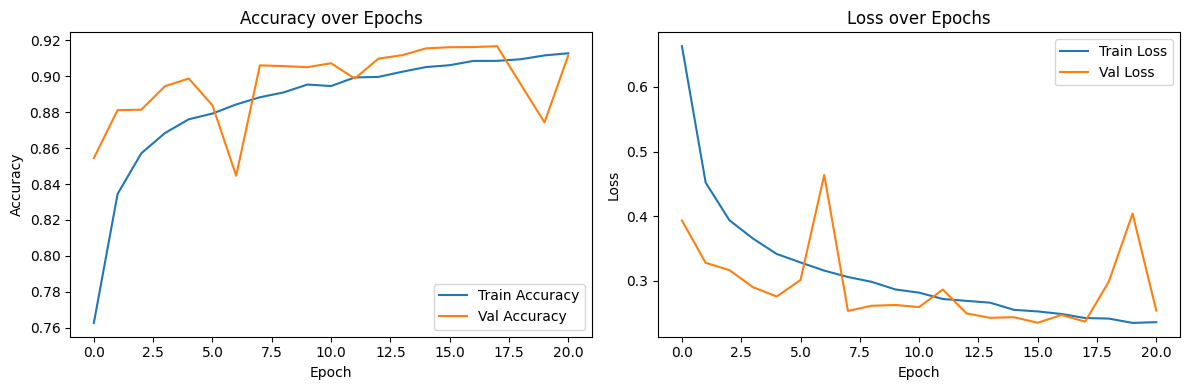

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


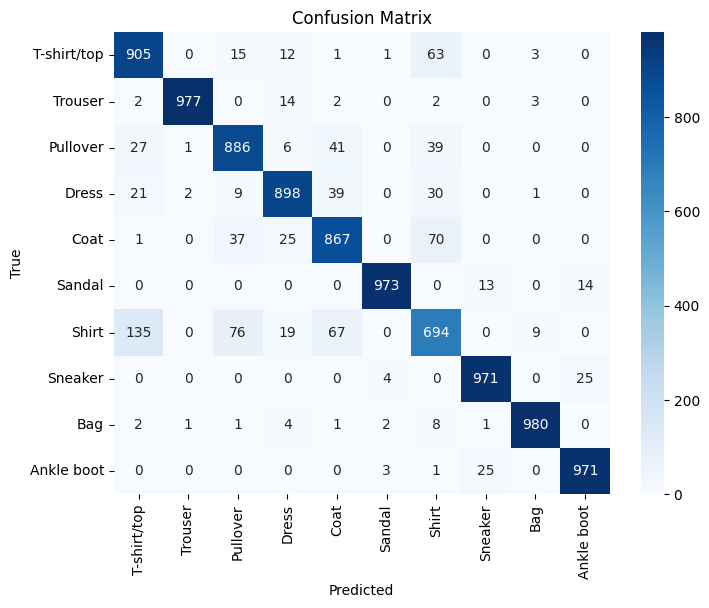

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.91      0.86      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.87      0.89      0.88      1000
       Dress       0.92      0.90      0.91      1000
        Coat       0.85      0.87      0.86      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.77      0.69      0.73      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.96      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [23]:
# Step 9: Analyze the Results
# Plot Training and Validation Curves
plt.figure(figsize=(12, 4))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix and Classification Report
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, y_pred_labels, target_names=class_names))

# Model Performance #

The CNN-based clothes classification model exhibits strong overall performance, achieving a final test accuracy of around 91.22% and a test loss of approximately 0.26. Throughout training, the accuracy curves for both the training and validation sets show steady improvement, starting near 80% and converging above 90% by the final epochs. Although the validation loss occasionally spikes, it generally trends downward alongside the training loss, indicating stable learning without extreme overfitting. The modest gap between training and validation accuracy suggests the model is generalizing reasonably well.<br>

Examining the confusion matrix reveals that most classes—especially Trouser, Sandal, Sneaker, and Bag—are classified with high accuracy, often exceeding 95%. The Shirt class, however, stands out as the most challenging category, with frequent misclassifications as T-shirt/top, Pullover, or Coat. This pattern is further reflected in the classification report, where Shirt’s recall (0.69) and F1-score (0.73) are noticeably lower than those of other classes. By contrast, Trouser demonstrates near-perfect precision and recall, and Sneaker and Bag also exhibit strong metrics with F1-scores around 0.98. <br>

Overall, the model’s high test accuracy, smooth training curves, and strong performance on most categories underscore its effectiveness. Nevertheless, addressing the misclassification of shirts remains a key opportunity for improvement. Strategies such as using targeted data augmentation and exploring deeper or more sophisticated network architectures could help the model better distinguish among visually similar classes. By focusing on these refinements, it is likely that the model’s accuracy and class-specific performance—particularly for Shirts—can be further enhanced.

In [ ]:
# Step 10: Save the Model (for later deployment)
model.save("fashion_mnist_cnn_model.keras")
print("Model saved successfully!")

# References #
Aggarwal, C. (2018). Neural networks and deep learning. Springer. ISBN-13: 9783319944623

Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. In F. Bach & D. Blei (Eds.), *Proceedings of the 32nd International Conference on Machine Learning (ICML)* (pp. 448–456). PMLR. [https://doi.org/10.48550/arXiv.1502.03167](https://doi.org/10.48550/arXiv.1502.03167)

Shanmugamani, R. (2018). Deep learning for computer vision. Packt Publishing. ISBN-13: 9781788293358

Scikit-learn. (n.d.). Preprocessing data. In Scikit-learn: Machine Learning in Python. Retrieved March 3, 2025, from https://scikit-learn.org/stable/modules/preprocessing.html 

Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms [Preprint]. arXiv. https://arxiv.org/abs/1708.07747 